In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/DS301\ Project

Mounted at /content/drive
/content/drive/MyDrive/DS301 Project


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [ ]:
file_path = 'goldprice2001.2.1--2024.1.1.xlsx'
df = pd.read_excel(file_path)
df.head()

,Date,Gold Price,USD Index,CPI,Fed Rate,sp500
0,2001-02-01,268.500000,109.660004,176.0,5.49,1373.469971
1,2001-02-02,267.100006,110.320000,176.0,5.49,1349.469971
2,2001-02-05,265.200012,109.889999,176.0,5.49,1354.310059
3,2001-02-06,263.299988,110.769997,176.0,5.49,1352.260010
4,2001-02-07,262.799988,110.889999,176.0,5.49,1340.890015


In [ ]:
features = ['Gold Price', 'USD Index', 'CPI', 'Fed Rate', 'sp500']
target = 'Gold Price'
window_size = 10

In [ ]:
X = []
y = []

for i in range(window_size, len(df)):
    X.append(df[features].iloc[i - window_size:i].values)  # shape: (10, 5)
    y.append(df[target].iloc[i])                            # scalar

X = np.array(X)  # shape: (N, 10, 5)
y = np.array(y).reshape(-1, 1)  # shape: (N, 1)

# Flatten for MLP: (10, 5) → (50,)
X = X.reshape(X.shape[0], -1)  # shape: (N, 50)

# Train/Val/Test Split
n = len(X)
train_end = int(n * 0.7)
val_end = int(n * 0.85)

X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create datasets
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_ds = TensorDataset(X_val_tensor, y_val_tensor)
test_ds = TensorDataset(X_test_tensor, y_test_tensor)

# Create data loaders
train_dl = DataLoader(train_ds, batch_size=64)
val_dl = DataLoader(val_ds, batch_size=64)

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
model = MLP(input_dim=X_train.shape[1])
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
current_lr = 0.01
switched = False  # flag to track if we've already changed LR

epochs = 200
for epoch in range(epochs):
    model.train()
    train_losses = []

    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    train_loss_epoch = sum(train_losses) / len(train_losses)

    # Validation
    model.eval()
    with torch.no_grad():
        val_pred = model(X_val_tensor)
        val_loss = loss_fn(val_pred, y_val_tensor).item()

    # Check for learning rate switch
    if not switched and val_loss < 2000:
        print(f"📉 Switching learning rate from 0.01 → 0.001 at epoch {epoch} (val loss = {val_loss:.2f})")
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.001
        current_lr = 0.001
        switched = True

    # Logging
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: LR = {current_lr:.5f}, Train Loss = {train_loss_epoch:.4f}, Validation Loss = {val_loss:.4f}")


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-7f943530503b>", line 3, in <cell line: 0>
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/optim/adam.py", line 99, in __init__
    super().__init__(params, defaults)
  File "/usr/local/lib/python3.11/dist-packages/torch/optim/optimizer.py", line 377, in __init__
    self.add_param_group(cast(dict, param_group))
  File "/usr/local/lib/python3.11/dist-packages/torch/_compile.py", line 27, in inner
    import torch._dynamo
  File "/usr/local/lib/python3.11/dist-packages/torch/_dynamo/__init__.py", line 3, in <module>
    from . import convert_frame, eval_frame, resume_execution
  File "/usr/local/lib/python3.11/dist-packages/torch/_dynamo/conver

In [ ]:
model.eval()
with torch.no_grad():
    test_pred = model(X_test_tensor).numpy()
    test_loss = loss_fn(torch.tensor(test_pred), y_test_tensor).item()

print(f"\nTest MSE Loss: {test_loss:.4f}")


Test MSE Loss: 2163.3057


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Convert y_test_tensor to NumPy
y_test_np = y_test_tensor.numpy()

# Compute metrics
mse = mean_squared_error(y_test_np, test_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_np, test_pred)
r2 = r2_score(y_test_np, test_pred)

# Print results
print(f"\nTest RMSE: {rmse:.4f}")
print(f"Test MAE:  {mae:.4f}")
print(f"Test R²:   {r2:.4f}")



Test RMSE: 46.5113
Test MAE:  39.1606
Test R²:   0.7582


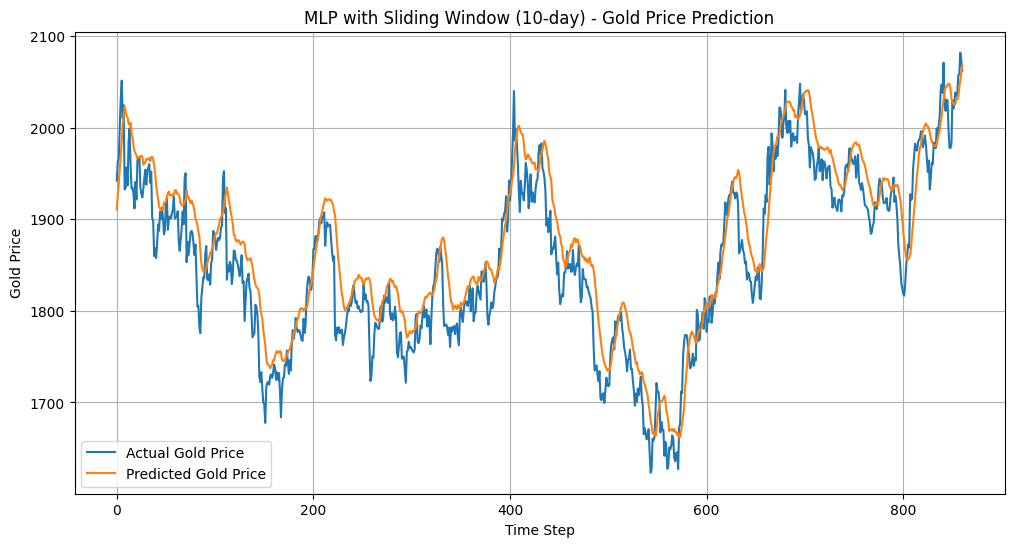

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Gold Price')
plt.plot(test_pred, label='Predicted Gold Price')
plt.title('MLP with Sliding Window (10-day) - Gold Price Prediction')
plt.xlabel('Time Step')
plt.ylabel('Gold Price')
plt.legend()
plt.grid(True)
plt.show()